In [1]:
import sys  
sys.path.insert(0, '../src/')

from plotting import plot_impedance
from metrics import show_SSIM_MSSIM, show_MSE_RMSE_MAE, soft_F_measure

In [2]:
import seaborn as sns
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from random import randint
from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d
import segyio
from shutil import copyfile
from numpy import genfromtxt

import scipy.stats as stats
import math

#added by orrafaellis:
from sklearn import model_selection
from keras import layers
import keras
import tensorflow as tf
from IPython.display import clear_output
#from livelossplot.keras import PlotLossesCallback

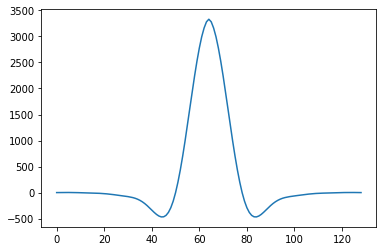

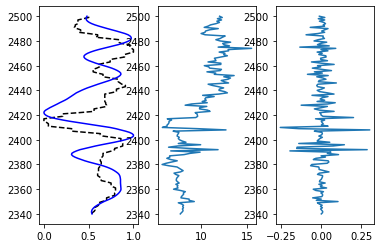

In [3]:
# Loading Impedance and seismic along well and checking if seismic using convolution matches the real seismic 

# Load seismic trace
seismic_data = genfromtxt('../data/volve/seismic_trace_15_9_F-15-A.csv', delimiter=';')

time_seismic = -np.round(seismic_data[:,0])
time_seismic, unique_indices = np.unique(time_seismic, return_index=True)
dt_seismic = time_seismic[1] - time_seismic[0]

seismic_trace = seismic_data[unique_indices,1]
Ip_trace = seismic_data[unique_indices,2]

start_time = 2340.0
end_time = 2500.0

seismic_trace_cropped = seismic_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
Ip_trace_cropped = Ip_trace[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]
time_cropped = time_seismic[np.where((time_seismic >= start_time) & (time_seismic <= end_time))]


# Load statistical source wavelet
source_statistical = genfromtxt('../data/volve/statistical_source_wavelet.txt', delimiter='	')
dt_source = 1e-3
plt.plot(source_statistical[:,1])
plt.show()


# Convolution of source with reflectivity series 
r0 = 0.5*np.diff(np.log(Ip_trace_cropped))
r0 = np.insert(r0,0, 0)
ss = np.convolve(r0, source_statistical[:,1], mode='same')
ss_normalized = (ss - np.min(ss))/(np.max(ss) - np.min(ss))

fig, axs = plt.subplots(1,3)
axs[0].plot(seismic_trace_cropped, time_cropped, '--k' )
axs[0].plot(1-ss_normalized, time_cropped, '-b' )
axs[1].plot(Ip_trace_cropped, time_cropped)
axs[2].plot(r0, time_cropped)

plt.show()


# Note to match 1-ss_normalized from impedance inversion

In [4]:
# Load stochastically generated impedance 
Ip = np.loadtxt('../data/volve/Ip_exported.txt')
Ip_reshape = np.reshape(Ip, ((151,151,160)), order='F')

In [5]:
# Trace by trace normalization and convolution 
ss_new = np.zeros(Ip_reshape.shape)
Ip_normalized = np.zeros(Ip_reshape.shape)
for i in range(Ip_reshape.shape[0]):
#     print('Iteration no: '+ str(i) + ' / '+ str(Ip_reshape.shape[0]))
    for j in range(Ip_reshape.shape[1]):
        Ip_trace = Ip_reshape[i,j,:]
        Ip_normalized[i,j,:] = Ip_trace#(Ip_trace - np.min(Ip_trace))/(np.max(Ip_trace) - np.min(Ip_trace))
        r0_trace = 0.5*np.diff(np.log(Ip_trace))
        r0_trace = np.insert(r0_trace,0, 0)
        ss_trace = np.convolve(r0_trace, source_statistical[:,1], mode='same')
        ss_new[i,j,:] = ss_trace#(ss_trace - np.min(ss_trace))/(np.max(ss_trace) - np.min(ss_trace))
            

## Normalização de todos os dados juntos 

In [6]:
seismic_norm = ss_new.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
ss_new = seismic_norm.reshape(ss_new.shape)


In [7]:
pimpedance_norm = Ip_normalized.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
Ip_normalized = pimpedance_norm.reshape(Ip_normalized.shape)
#seismic_norm = seismic

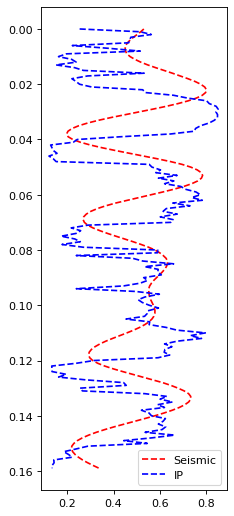

In [8]:
# Plot of results of convolution
time_new = np.arange(0,ss_new.shape[2]*1e-3, 1e-3)
nx = 100
ny = 100
# Ip_trace_normalized = (Ip_reshape[nx, ny, :] - np.min(Ip_reshape[nx, ny, :] ))/(np.max(Ip_reshape[nx, ny, :] ) - np.min(Ip_reshape[nx, ny, :] ))

plt.figure(num=None, figsize=(3, 8), dpi=80, facecolor='w', edgecolor='k')
plt.plot(ss_new[nx,ny,:], time_new, '--r',label='Seismic')
plt.plot(Ip_normalized[nx,ny,:], time_new, '--b',label='IP')
plt.legend()
plt.gca().invert_yaxis()

In [9]:
# Creating training, validation and test data 

# Validation dataset created near the area of the well
indx_i_well_start = 20
indx_i_well_end = 45
indx_j_well_start = 32
indx_j_well_end = 54

valX = ss_new[indx_i_well_start:indx_i_well_end, indx_j_well_start:indx_j_well_end, :]
valX = valX.reshape(-1, valX.shape[-1])
valX = np.expand_dims(valX,axis=(2,3))

valIp = Ip_normalized[indx_i_well_start:indx_i_well_end, indx_j_well_start:indx_j_well_end, :]
valIp = valIp.reshape(-1, valIp.shape[-1])
valIp = np.expand_dims(valIp,axis=(2,3))

In [10]:
# Flatten rest of indices 
ss_data_rest = ss_new[np.r_[0:(indx_i_well_start-1),(indx_i_well_end+1):ss_new.shape[0]], :, :]
ss_data_rest = ss_data_rest[:, np.r_[0:(indx_j_well_start-1),(indx_j_well_end+1):ss_new.shape[1]],:]
ss_data_rest = ss_data_rest.reshape(-1, ss_data_rest.shape[-1])
ss_data_rest = np.expand_dims(ss_data_rest,axis=(2,3))

Ip_data_rest = Ip_normalized[np.r_[0:(indx_i_well_start-1),(indx_i_well_end+1):Ip_normalized.shape[0]], :, :]
Ip_data_rest = Ip_data_rest[:, np.r_[0:(indx_j_well_start-1),(indx_j_well_end+1):Ip_normalized.shape[1]],:]
Ip_data_rest = Ip_data_rest.reshape(-1, Ip_data_rest.shape[-1])
Ip_data_rest = np.expand_dims(Ip_data_rest,axis=(2,3))

In [11]:
# Selecting randomly training dataset
howMany = 750 # Seismic data considered out of all data points 
np.random.seed(9) # For replication of results
indxRand = [randint(0,ss_data_rest.shape[0]-1) for p in range(0,howMany)]

X_train = (ss_data_rest[indxRand,:,:,:])
Y_train = (Ip_data_rest[indxRand,:,:,:])

In [12]:
all_valid_loc = np.arange(valIp.shape[0])

valid_wells_loc, unlabed_wells_loc = model_selection.train_test_split(all_valid_loc,
                                                                      test_size=0.5,
                                                                      train_size=0.5,
                                                                      random_state=9, 
                                                                      shuffle=True)

In [13]:
X_valid = valX[valid_wells_loc,:,:,:]
Y_valid = valIp[valid_wells_loc,:,:,:]

UNLABED_SEISMIC = valX[unlabed_wells_loc,:,:,:] 

In [14]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

print('     IP (Y_valid) shape: ',Y_valid.shape)
print('seismic (X_valid) shape: ',X_valid.shape)

#print('     IP (Y_test) shape: ',Y_test.shape)
#print('seismic (X_test) shape: ',X_test.shape)

     IP (Y_train) shape:  (750, 160, 1, 1)
seismic (X_train) shape:  (750, 160, 1, 1)
     IP (Y_valid) shape:  (275, 160, 1, 1)
seismic (X_valid) shape:  (275, 160, 1, 1)


## Create the Generator

In [15]:
def get_generator_model():
    noise = layers.Input(shape=(160,1,1))

    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(noise)
    GEN = layers.BatchNormalization()(noise)
    GEN = layers.ReLU()(GEN)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
        
    GEN = layers.Conv2D(filters=1,kernel_size=(3,1),strides=(1,1),padding='same')(GEN)

    GENmodel = keras.models.Model(inputs=noise,outputs=GEN)
    return GENmodel

f_model = get_generator_model()

In [16]:
import keras
import tensorflow as tf
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True) 
        plt.plot(self.x[-100:], self.losses[-100:], label="Training Loss")
        plt.plot(self.x[-100:], self.val_losses[-100:], label="Validation Loss")
        plt.title('Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [17]:
f_model = get_generator_model()
f_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 1, 1)]  0                                            
__________________________________________________________________________________________________
batch_normalization_7 (BatchNor (None, 160, 1, 1)    4           input_2[0][0]                    
__________________________________________________________________________________________________
re_lu_7 (ReLU)                  (None, 160, 1, 1)    0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 160, 1, 16)   1296        re_lu_7[0][0]                    
____________________________________________________________________________________________

In [18]:
optimizer = keras.optimizers.Adam(learning_rate = 0.001)
#compile model using accuracy to measure model performance

f_model.compile(optimizer=optimizer, loss='mse')

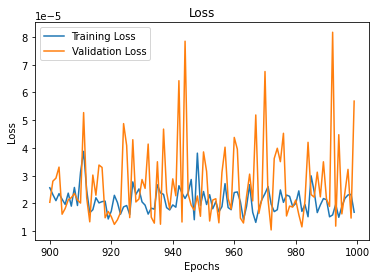

In [19]:
## train the model
f_model_history = f_model.fit(Y_train, X_train,
                              validation_data=(Y_valid, X_valid),
                              epochs=1000,
                              verbose=1,
                              shuffle=True,
                              batch_size=10,
                              #callbacks = [plot_losses]
                             )

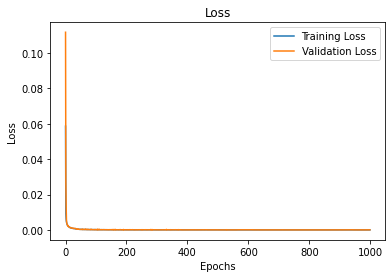

In [20]:
plt.plot(f_model_history.history['loss'])
plt.plot(f_model_history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [21]:
predict = f_model(valIp)[:,:,0,0]

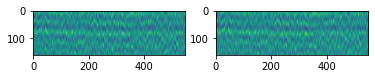

In [22]:
predict = np.transpose(predict.numpy())
fig1, axes1 = plt.subplots(nrows=1, ncols=2)
axes1[0].imshow(predict)
axes1[1].imshow(np.transpose(valX[:,:,0,0]))

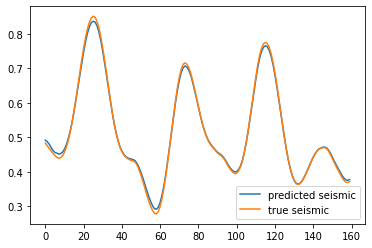

In [23]:
test_trace = np.random.randint(predict.shape[1])
plt.plot(predict[:,test_trace],label='predicted seismic')
plt.plot(valX[test_trace,:,0,0],label='true seismic')
plt.legend()

## Inversion WGAN-GP

In [24]:
BATCH_SIZE = 75
N_EPOCHS = 2000
noise_dim = 160
IMG_SHAPE = (160,1,1)

In [25]:
def get_generator_model():
    noise = layers.Input(shape=(noise_dim,1,1))

    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(noise)
    GEN = layers.BatchNormalization()(noise)
    GEN = layers.ReLU()(GEN)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
    
    GEN = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(GEN)
    RB = layers.BatchNormalization()(GEN)
    RB = layers.ReLU()(RB)
    RB = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(RB)
    RB = layers.BatchNormalization()(RB)
    RB = layers.Add()([RB,GEN])
    GEN = layers.ReLU()(RB)
        
    GEN = layers.Conv2D(filters=1,kernel_size=(3,1),strides=(1,1),padding='same')(GEN)

    GENmodel = keras.models.Model(inputs=noise,outputs=GEN)
    return GENmodel

### Create the discriminator (the critic in the original WGAN)

In [26]:
def get_discriminator_model():       
    input_disc = layers.Input(shape=IMG_SHAPE)        
    ENC = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same',strides=2)(input_disc)
    ENC = layers.LeakyReLU()(ENC)
    ENC = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENC)
        
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(ENC)
    ENCB1 = layers.ReLU()(ENCB1)
    ENCB1 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB1)
    ENCB1 = layers.Add()([ENCB1, ENC])
    ENCB1 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB1)
    ENCB1 = layers.ReLU()(ENCB1)
        
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(ENCB1)
    ENCB2 = layers.ReLU()(ENCB2)
    ENCB2 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB2)
    ENCB2 = layers.Add()([ENCB2, ENCB1])
    ENCB2 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB2)
    ENCB2 = layers.ReLU()(ENCB1)
        
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(80,1),padding='same')(ENCB2)
    ENCB3 = layers.ReLU()(ENCB3)
    ENCB3 = layers.Conv2D(filters=16,kernel_size=(3,1),padding='same')(ENCB3)
    ENCB3 = layers.Add()([ENCB2, ENCB3])
    ENCB3 = layers.MaxPooling2D(pool_size=(1,1),strides=(2,1))(ENCB3)
    ENCB3 = layers.ReLU()(ENCB3)
        
    r1 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=1)(ENCB3)
    r1 = layers.BatchNormalization()(r1)
    r1 = layers.ReLU()(r1)
    r2 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=3)(ENCB3)
    r2 = layers.BatchNormalization()(r2)
    r2 = layers.ReLU()(r2)
    r3 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=5)(ENCB3)
    r3 = layers.BatchNormalization()(r3)
    r3 = layers.ReLU()(r3)
    r4 = layers.Conv2D(filters=32,kernel_size=(3,1),padding='same',dilation_rate=7)(ENCB3)
    r4 = layers.BatchNormalization()(r4)
    r4 = layers.ReLU()(r4)
    assp = layers.concatenate([r1,r2,r3,r4])
    assp = layers.Conv2D(filters=64,kernel_size=(3,1),padding='same',strides=2)(assp)
        
        
    fc_out = layers.Dense(256,kernel_initializer=tf.keras.initializers.HeNormal())(assp)
    lkr_out = layers.LeakyReLU()(fc_out)
    fc2_outFlatten = layers.Flatten()(lkr_out)
    fc2_out = layers.Dense(1,kernel_initializer=tf.keras.initializers.HeNormal())(fc2_outFlatten)
        
    DISCmodel = keras.models.Model(inputs=input_disc,outputs=fc2_out)
    return DISCmodel

### Create the WGAN-GP models

In [27]:
class WGAN(keras.Model):
    def __init__(
        self,
        discriminator,
        generator,
        latent_dim,
        discriminator_extra_steps=3,
        gp_weight=10.0,
        alpha_weight = 1000,
        beta_weight = 500
    ):
        super(WGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        self.alpha_weight = alpha_weight
        self.beta_weight = beta_weight

    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn, imp_loss_fn, seis_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        self.imp_loss_fn = imp_loss_fn
        self.seis_loss_fn = seis_loss_fn

    def gradient_penalty(self, batch_size, real_images, fake_images):
        
        alpha = tf.random.normal([batch_size, 1, 1,1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
       
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        noises_input,real_images = data
        if isinstance(real_images, tuple):
            real_images = real_images[0]

        batch_size = tf.shape(real_images)[0]

        random_latent_vectors = noises_input
        
        for i in range(self.d_steps):

            with tf.GradientTape() as tape:
                
                fake_images = self.generator(random_latent_vectors, training=True)
                fake_logits = self.discriminator(fake_images, training=True)

                real_logits = self.discriminator(real_images, training=True)

                # discriminator loss
                d_cost = self.d_loss_fn(real_img=real_logits, fake_img=fake_logits)
                
                # gradient penalty
                gp = self.gradient_penalty(batch_size, real_images, fake_images)
                
                d_loss = d_cost + gp * self.gp_weight 
            
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        # Unlabed seismic mini-batch:
        unlabed_wells_loc = np.arange(UNLABED_SEISMIC.shape[1])
        np.random.shuffle(unlabed_wells_loc)
        unlabed_batch_idxs = unlabed_wells_loc[0:BATCH_SIZE]
        unlabed_batch = UNLABED_SEISMIC[unlabed_batch_idxs,:,:,:]
        
        with tf.GradientTape() as tape:
            
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training=True)
            
            #Generator loss
            g_cost = self.g_loss_fn(gen_img_logits)
            
            #Impedance loss
            imp_loss = self.imp_loss_fn(generated_images, real_images)
                        
            #Seismic loss:
            fake_seis_unlabed = f_model(self.generator(unlabed_batch,training=True))
            seis_cost = self.seis_loss_fn(fake_seis_unlabed,unlabed_batch)
            
            g_loss = g_cost + self.alpha_weight * imp_loss + self.beta_weight * seis_cost
            
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        
        return {"d_loss": d_loss, "g_loss": g_loss,"imp_loss":(self.alpha_weight * imp_loss),"seis_loss":(self.beta_weight * seis_cost)}

### CallBacks

In [28]:
checkp_callback = keras.callbacks.ModelCheckpoint(filepath='best_model.hdf5',
                                             monitor='imp_loss',
                                             verbose=2,
                                             save_best_only=True,
                                             mode='min')

earlystop_callback =  tf.keras.callbacks.EarlyStopping(monitor='imp_loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=2, 
            patience=600)

nan_callback = tf.keras.callbacks.TerminateOnNaN()

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.d_losses = []
        self.g_losses = []
        self.imp_losses = []
        self.seis_losses =[]
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.d_losses.append(logs.get('d_loss'))
        self.g_losses.append(logs.get('g_loss'))
        self.imp_losses.append(logs.get('imp_loss'))
        self.seis_losses.append(logs.get('seis_loss'))
        self.i += 1
        
        clear_output(wait=True) 
        if self.i>50:
            plt.plot(self.x[-100:], self.d_losses[-100:], label="d_loss")
            plt.plot(self.x[-100:], self.g_losses[-100:], label="g_loss")
            plt.plot(self.x[-100:], self.imp_losses[-100:], label="imp_loss")
            plt.plot(self.x[-100:], self.seis_losses[-100:], label="seis_loss")
        else:
            plt.plot(self.x, self.d_losses, label="d_loss")
            plt.plot(self.x, self.g_losses, label="g_loss")
            plt.plot(self.x, self.imp_losses, label="imp_loss")
            plt.plot(self.x, self.seis_losses, label="seis_loss")
        plt.legend()
        plt.show();
        
plot_callback = PlotLosses()

### Train the end-to-end model

In [29]:
#Initialize internal models: 
g_model = get_generator_model()
d_model = get_discriminator_model()

#optimizers:
generator_optimizer = keras.optimizers.Adam(learning_rate=0.001)
discriminator_optimizer = keras.optimizers.Adam(learning_rate = 0.001)

# All needed losses:
def discriminator_loss(real_img, fake_img):
    real_loss = tf.reduce_mean(real_img)
    fake_loss = tf.reduce_mean(fake_img)
    return fake_loss - real_loss

def generator_loss(fake_img):
    return -tf.reduce_mean(fake_img)

def impedance_loss(fake_imp,real_imp):
    imp_mse = tf.keras.metrics.mean_squared_error(real_imp, fake_imp)
    return imp_mse

def seismic_loss(fake_seis,real_seis):
    seis_loss = tf.keras.metrics.mean_squared_error(real_seis, fake_seis)
    return seis_loss


wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=160,
    discriminator_extra_steps=5,
    alpha_weight = 1000,
    beta_weight = 500,
    gp_weight = 10
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
    imp_loss_fn = impedance_loss,
    seis_loss_fn = seismic_loss
)

In [45]:
d_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 160, 1, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 80, 1, 16)    1296        input_4[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 80, 1, 16)    0           conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 40, 1, 16)    0           leaky_re_lu[0][0]                
____________________________________________________________________________________________

In [30]:
# Initialize model training:
wgan_history = wgan.fit(X_train,
                        Y_train,
                        shuffle=True,
                        batch_size=BATCH_SIZE,
                        epochs=N_EPOCHS,
                        verbose = 1,
                        #callbacks=[checkp_callback]
                       )

Epoch 1/2000
10/10 [==============================] - 19s 170ms/step - d_loss: -2.6995 - g_loss: 558.9470 - imp_loss: 534.3528 - seis_loss: 19.6994A: 0s - d_loss: -4.1700 - g_loss: 989.9575 - imp_loss: 956.6757 - seis_loss: 27.736 - ETA: 0s - d_loss: -3.0766 - g_loss: 706.7692 - imp_loss: 679.3070 - seis_loss: 22.665 - ETA: 0s - d_loss: -2.9525 - g_loss: 648.9723 - imp_loss: 622.7546 - seis_loss: 21.49
Epoch 2/2000
10/10 [==============================] - 1s 126ms/step - d_loss: -0.6311 - g_loss: 107.5180 - imp_loss: 88.8133 - seis_loss: 11.6467
Epoch 3/2000
10/10 [==============================] - 1s 142ms/step - d_loss: -0.5255 - g_loss: 73.5768 - imp_loss: 58.7816 - seis_loss: 7.1142
Epoch 4/2000
10/10 [==============================] - 1s 134ms/step - d_loss: -0.8178 - g_loss: 57.6477 - imp_loss: 46.2302 - seis_loss: 5.29570s - d_loss: -0.7627 - g_loss: 62.3594 - imp_loss: 49.6973 - sei
Epoch 5/2000
10/10 [==============================] - 1s 126ms/step - d_loss: -0.6434 - g_loss: 

In [31]:
X_predict = wgan.generator(valX)[:,:,0,0]
X_predict = np.transpose(X_predict)


y_predicted = wgan.generator(valX)[:,:,0].numpy()

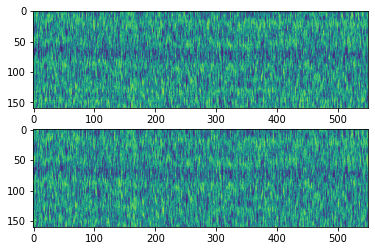

In [32]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1)
axes1[0].imshow(X_predict)
axes1[1].imshow(np.transpose(valIp[:,:,0,0]))

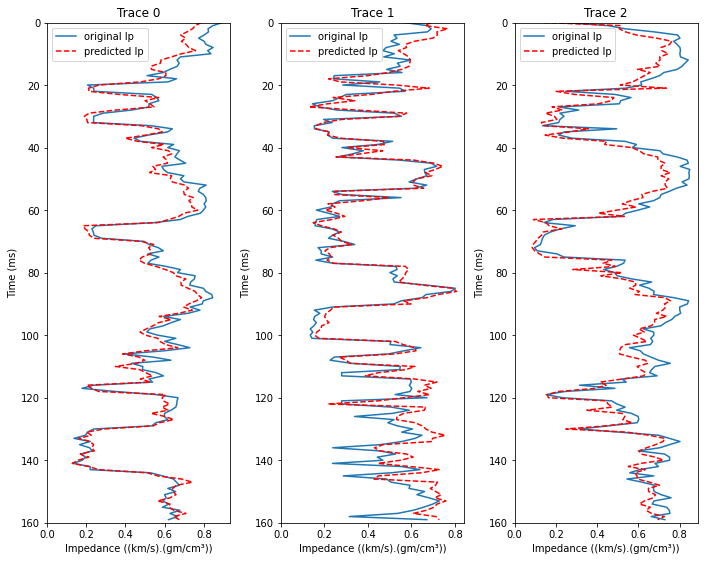

In [33]:
plot_impedance(n=3,
              valIp=valIp,
              X_predict=X_predict)

y_test = valIp[:,:,0]

In [34]:
(target_image, predict_image) = show_SSIM_MSSIM(y_predicted=y_predicted,
                                                y_test=y_test)

SSIM:  0.932989
SSIM Multiscale:  0.97169256


In [35]:
(mse_res, mae_res, m) = show_MSE_RMSE_MAE(target_image,
                                          predict_image)

print(f"MSE: ", mse_res)
print("MAE: ", mae_res)
print("RMSE: ", m.result().numpy())

MSE:  0.004873484
MAE:  0.05273351
RMSE:  0.069810346


In [36]:
Fb = soft_F_measure(target_data=target_image[:,:,0],
                    predicted_data=predict_image[:,:,0],                 
                    canny_sigma=0.5,
                    gaussian_sigma=0.5,
                    beta_F1=1)

print(Fb)

0.6508956516833575


## Train baseline: CNN = generator

In [37]:
cnn_inversion = get_generator_model()

optimizer_cnn = keras.optimizers.Adam(learning_rate = 0.001)

cnn_inversion.compile(optimizer=optimizer_cnn, loss='mse')

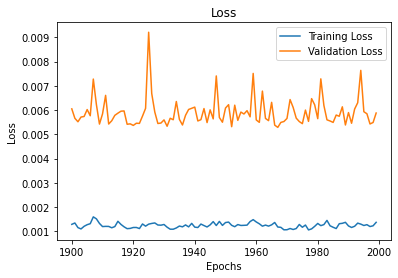

In [39]:
cnn_history = cnn_inversion.fit(X_train,
                                Y_train,
                                validation_data=(X_valid,Y_valid),
                                epochs=N_EPOCHS,
                                verbose=1,
                                shuffle=True,
                                batch_size=BATCH_SIZE,
                                #callbacks = [plot_losses]
                               )

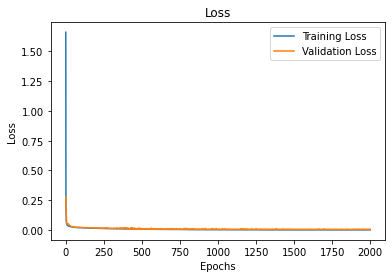

In [40]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

In [41]:
X_predictCNN = cnn_inversion(valX)[:,:,0,0]
X_predictCNN = np.transpose(X_predictCNN)

y_predictCNN = cnn_inversion(valX)[:,:,0].numpy()

Text(0.5, 1.0, 'CNN inversion')

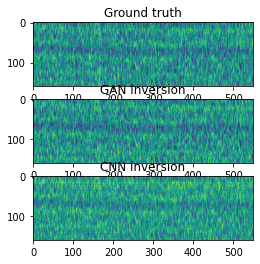

In [42]:
fig1, axes1 = plt.subplots(nrows=3, ncols=1)
axes1[0].imshow(np.transpose(valIp[:,:,0,0]))
axes1[0].set_title("Ground truth")

axes1[1].imshow(X_predict)
axes1[1].set_title("GAN Inversion")

axes1[2].imshow(X_predictCNN)
axes1[2].set_title("CNN inversion")

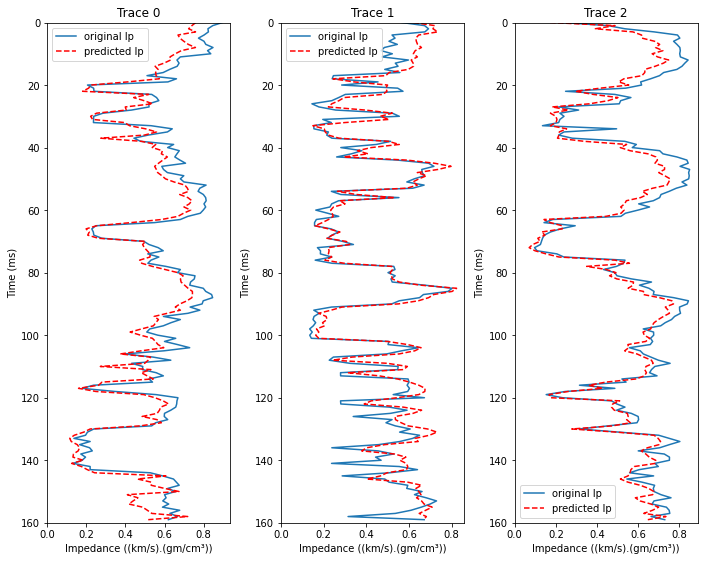

In [43]:
plot_impedance(n=3,
              valIp=valIp,
              X_predict=X_predictCNN)

y_test = valIp[:,:,0]

In [44]:
(targetCNN, predictCNN) = show_SSIM_MSSIM(y_predicted=y_predictCNN,
                        y_test=y_test)

(mse_cnn, mae_cnn, mcnn) = show_MSE_RMSE_MAE(targetCNN,
                                          predictCNN)

print(f"MSE: ", mse_cnn)
print("MAE: ", mae_cnn)
print("RMSE: ", mcnn.result().numpy())

SSIM:  0.9146221
SSIM Multiscale:  0.96344477
MSE:  0.006088343
MAE:  0.059139498
RMSE:  0.07802784
